# Experiments


<br>

### Imports

In [4]:
import numpy as np
import pandas as pd

import copy
from tqdm import tqdm

from sklearn.inspection import permutation_importance
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from evtdemand import suite, data, feature

In [5]:
from IPython.display import JSON

import matplotlib.pyplot as plt

In [1]:
default_params = {
    'data_dir': '../data',
    'model_1': 'lightgbm.LGBMRegressor', 
    'model_2': 'lightgbm.LGBMRegressor',
    'model_1_kwargs': {
        'num_leaves': 50,
        'n_estimators': 100,
        'reg_lambda': 0.1
    },
    'model_2_kwargs': {
        'num_leaves': 50,
        'n_estimators': 100,
        'reg_lambda': 0.1
    },
    'data_kwargs': {
        'real_power_sub_dir': 'real_power',
        'weather_sub_dir': 'weather',
        'real_power_time_period': '_pre_august',
        'real_power_site': 'Staplegrove_CB905',
        'weather_grid_point': 'staplegrove_1',
        'weather_interpolate_method': 'interpolate',
        'use_target_delta': False
    },
    'y1_col': 'value_max',
    'y2_col': 'value_min',
    'split_kwargs': {
        'n_splits': 5, 
        'shuffle': False
    },
    'cols_subset': ['value', 'temperature', 'solar_irradiance', 'pressure',
                    'spec_humidity', 'hour', 'local_hour', 'windspeed_north', 
                    'windspeed_east', 'doy', 'speed', 'direction', 'weekend', 'hcdh'],#, 'prev_month_max_avg',
                    #'prev_month_max_max', 'prev_month_min_avg', 'prev_month_min_min'],
    'features_kwargs': {
        'features': ['temporal', 'dir_speed', 'hcdh']
    }
}

In [8]:
df_features, df_target = data.construct_baseline_features_target_dfs(default_params['data_dir'], **default_params['data_kwargs'])
df_features = feature.create_additional_features(df_features, df_target, **default_params['features_kwargs'])
df_features = feature.process_features(df_features, cols_subset=default_params['cols_subset'])

Wall time: 3.56 s


{'y1_rmse': 10.389345154377155,
 'y2_rmse': 11.177505324655117,
 'combined_rmse': 15.305702367282791,
 'skill_score': 0.5152324587016828}

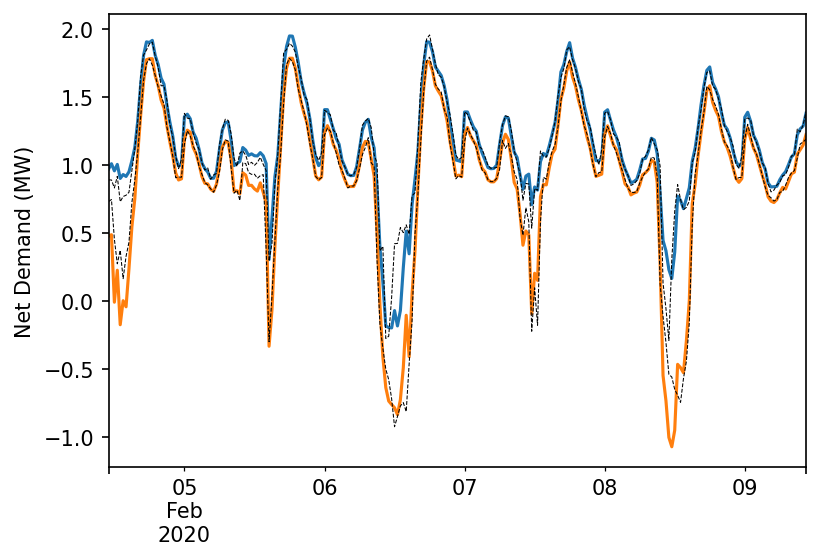

In [9]:
%%time

model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**default_params)
suite.plot_pred_sample(df_pred, df_target)

error_metrics

Wall time: 6.34 s


{'y1_rmse': 74.22773131992435,
 'y2_rmse': 74.76233431336969,
 'combined_rmse': 105.36103081492145,
 'skill_score': 0.9480936610690321}

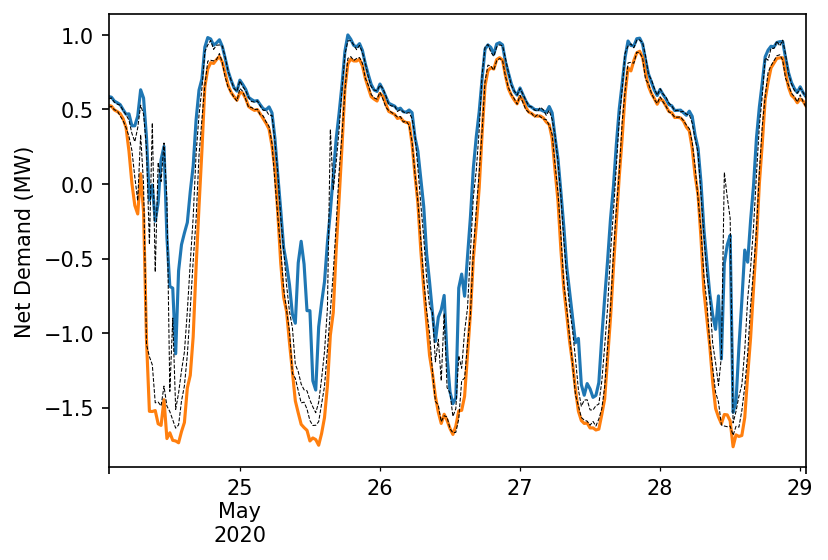

In [7]:
%%time

params = copy.deepcopy(default_params)

params['data_kwargs']['use_target_delta'] = True
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
suite.plot_pred_sample(df_pred, df_target)

error_metrics

In [9]:
%%time 

# comparing the two wind speed encodings

params = copy.deepcopy(default_params)

params['cols_subset'] = ['value', 'temperature', 'solar_irradiance', 'pressure',
                         'spec_humidity', 'hour', 'doy', 'speed', 'direction', 'weekend', 'hcdh']
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
vectors_error = error_metrics['skill_score']

params['cols_subset'] = ['value', 'temperature', 'solar_irradiance', 'pressure', 'spec_humidity', 
                         'hour', 'windspeed_north', 'windspeed_east', 'doy', 'weekend', 'hcdh']
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
speed_dir_error = error_metrics['skill_score']

params['cols_subset'] = ['value', 'temperature', 'solar_irradiance', 'pressure', 'spec_humidity', 'speed', 
                         'direction', 'hour', 'windspeed_north', 'windspeed_east', 'doy', 'weekend', 'hcdh']
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
both_error = error_metrics['skill_score']


vectors_error, speed_dir_error, both_error

Wall time: 21.3 s


(0.5173457556059888, 0.5149958383696378, 0.5152324587016828)

In [12]:
%%time 

# comparing the local and utc hour features

params = copy.deepcopy(default_params)

params['cols_subset'] = ['value', 'temperature', 'solar_irradiance', 'pressure',
                         'spec_humidity', 'hour', 'doy', 'speed', 'direction', 'weekend', 'hcdh']
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
utc_hour_error = error_metrics['skill_score']

params['cols_subset'] = ['value', 'temperature', 'solar_irradiance', 'pressure', 'spec_humidity', 
                         'local_hour', 'windspeed_north', 'windspeed_east', 'doy', 'weekend', 'hcdh']
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
local_hour_error = error_metrics['skill_score']

params['cols_subset'] = ['value', 'temperature', 'solar_irradiance', 'pressure', 'spec_humidity', 
                         'hour', 'local_hour', 'windspeed_north', 'windspeed_east', 'doy', 'weekend', 'hcdh']
model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
both_hours_error = error_metrics['skill_score']


utc_hour_error, local_hour_error, both_hours_error

Wall time: 20.4 s


(0.5173457556059888, 0.5129837273817897, 0.512808435323487)

In [6]:
# investigating the impact of reduced training size

df_results = pd.DataFrame()
all_input_data = []
test_splits = list(range(2, 7))
params = copy.deepcopy(default_params)

for run_id, test_split in tqdm(enumerate(test_splits), total=len(test_splits)):    
    params['split_kwargs'] = {'n_splits': test_split, 'shuffle': False}
    model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)
    
    df_results = df_results.append(pd.DataFrame([error_metrics], index=[run_id]))
    all_input_data += [input_data]

df_results.index.name = 'run_id'
    
df_results

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.68s/it]


,y1_rmse,y2_rmse,combined_rmse,skill_score
run_id,,,,
0,17.657929,17.963724,25.195639,0.522551
1,14.212972,14.888986,20.606912,0.526670
2,11.898792,12.542129,17.324525,0.522463
3,10.389345,11.177505,15.305702,0.515232
4,9.622927,10.113562,14.011024,0.522844


In [7]:
%%time

# tuning lightgbm params

params = copy.deepcopy(default_params)

params['model_1'] = 'lightgbm.LGBMRegressor'
params['model_2'] = 'lightgbm.LGBMRegressor'
params['model_1_kwargs'] = {
    'num_leaves': 50,
    'n_estimators': 100,
    'reg_lambda': 0.1
}
params['model_2_kwargs'] = {
    'num_leaves': 50,
    'n_estimators': 100,
    'reg_lambda': 0.1
}

model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)

error_metrics

Wall time: 6.16 s


{'y1_rmse': 10.389345154377155,
 'y2_rmse': 11.177505324655117,
 'combined_rmse': 15.305702367282791,
 'skill_score': 0.5152324587016828}

In [37]:
%%time

# tuning xgboost params

params = copy.deepcopy(default_params)

params['model_1'] = 'xgboost.XGBRegressor'
params['model_2'] = 'xgboost.XGBRegressor'
params['model_1_kwargs'] = {
    'max_depth': 3,
    'min_child_weight': 1,
    'eta': 0.2,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
}
params['model_2_kwargs'] = {
    'max_depth': 3,
    'min_child_weight': 1,
    'eta': 0.2,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
}

model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**params)

error_metrics

Wall time: 19.3 s


{'y1_rmse': 10.480886415534037,
 'y2_rmse': 11.635572301565517,
 'combined_rmse': 15.711933251348455,
 'skill_score': 0.5287247045208947}

In [36]:
# 0.52872470 <- max_depth=3, eta=0.2

In [6]:
# assessing feature importance

model_1 = suite.load_module_attr(default_params['model_1'])(**default_params['model_1_kwargs'])
model_2 = suite.load_module_attr(default_params['model_2'])(**default_params['model_2_kwargs'])

model_1

LGBMRegressor(num_leaves=50, reg_lambda=0.1)

In [18]:
def clean_subsets(sfs):
    subsets = sfs.subsets_

    for idx, res in subsets.items():
        res['cv_scores'] = list(res['cv_scores'])

    return subsets

In [19]:
%%time

X, y = df_features.values, df_target['value_max'].values

sfs1 = SFS(model_1, 
           k_features=df_features.shape[1], 
           forward=True, 
           floating=False, 
           verbose=1,
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X, y)

JSON(clean_subsets(sfs1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    6.8s finished
Features: 1/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    5.5s finished
Features: 2/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
Features: 3/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s finished
Features: 4/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.6s finished
Features: 5/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.0s finished
Features: 6/13[Parallel(

Wall time: 45.8 s


<IPython.core.display.JSON object>

In [20]:
%%time

X, y = df_features.values, df_target['value_max'].values

sfs2 = SFS(model_1, 
           k_features=10, 
           forward=False, 
           floating=False, 
           verbose=1,
           scoring='neg_mean_squared_error',
           cv=0)

sfs2 = sfs2.fit(X, y)

JSON(clean_subsets(sfs2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    8.4s finished
Features: 12/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    7.6s finished
Features: 11/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    6.5s finished
Features: 10/10

Wall time: 23.5 s


<IPython.core.display.JSON object>

In [20]:
%%time

X, y = df_features.values, df_target['value_max'].values
model_1.fit(X, y)

result = permutation_importance(
    model_1, X, y, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=df_features.columns)

forest_importances.sort_values(ascending=False)

Wall time: 16.4 s


value               1.931557
hour                0.020073
doy                 0.016353
pressure            0.012139
spec_humidity       0.011056
solar_irradiance    0.010787
windspeed_east      0.010363
temperature         0.007676
windspeed_north     0.004392
speed               0.003682
hcdh                0.003653
direction           0.002466
weekend             0.001439
dtype: float64

In [43]:
%%time

X, y = df_features.values, df_target['value_min'].values
model_2.fit(X, y)

result = permutation_importance(
    model_2, X, y, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=df_features.columns)

forest_importances.sort_values(ascending=False)

Wall time: 9.53 s


value               1.620178
hour                0.018918
solar_irradiance    0.018652
doy                 0.014086
windspeed_east      0.005720
spec_humidity       0.005241
pressure            0.005102
speed               0.002317
windspeed_north     0.001869
temperature         0.001845
direction           0.001500
hcdh                0.000791
weekend             0.000635
dtype: float64